# 取得 GoogleDrive 資料夾權限

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 切換路徑

In [ ]:
%cd /content/drive/My Drive/

/content/drive/My Drive


# 硬體資源檢查

## 查看分配的GPU

In [ ]:
! /opt/bin/nvidia-smi

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


## 查看環境版本

In [ ]:
! python --version

Python 3.7.12


In [ ]:
import torch
print(torch.__version__)

1.10.0+cu111


# 建立硬體資源檢查函式



In [ ]:
def device_setter() -> torch.device:
    return torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')

device_setter()

device(type='cpu')

# 透過 ImageFolder 取得資料夾的資料集
- torchvision.datasets.ImageFolder


In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
import torchvision.transforms as transforms
img_dataset = ImageFolder(root='/content/drive/MyDrive/lesson_dataset',
                          transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Resize((256, 256))])
                          )

## 取得資料集類別

In [ ]:
img_dataset.classes

['monitor', 'mouse', 'mug']

## 取得圖片路徑和處理後的類別

In [ ]:
img_dataset.samples

In [ ]:
img_dataset.samples[0][0]

'/content/drive/MyDrive/lesson_dataset/monitor/frame_0001.jpg'

# 透過 DataLoader 批次讀取圖片
- torch.utils.data.DataLoader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
img_data_loader = DataLoader(
      dataset=img_dataset,
      num_workers=2,
      batch_size=1,
      shuffle=True
    )

for iteration_num, (input_data, data_label) in enumerate(img_data_loader):
    print(input_data)
    print(input_data.shape)
    print(input_data[0].shape)
    print('-' * 50)
    print(data_label)
    print(data_label.item())
    break

tensor([[[[0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
          [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
          [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
          ...,
          [0.9765, 0.9740, 0.9698,  ..., 0.3542, 0.3493, 0.3557],
          [0.9765, 0.9740, 0.9698,  ..., 0.3495, 0.3466, 0.3529],
          [0.9765, 0.9740, 0.9698,  ..., 0.3495, 0.3466, 0.3529]],

         [[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.9137, 0.9113, 0.9070,  ..., 0.4039, 0.4160, 0.4224],
          [0.9137, 0.9113, 0.9070,  ..., 0.4051, 0.4132, 0.4196],
          [0.9137, 0.9113, 0.9070,  ..., 0.4051, 0.4132, 0.4196]],

         [[0.9765, 0.9765, 0.9765,  ..., 0.9765, 0.9765, 0.9765],
          [0.9765, 0.9765, 0.9765,  ..., 0.9765, 0.9765, 0.9765],
          [0.9765, 0.9765, 0.9765,  ..., 0

# 透過 random_split 拆分資料組別
- torch.utils.data.random_split

In [ ]:
# from torch import manual_seed
# from torch import initial_seed
from torch.utils.data import random_split
from typing import Tuple


In [ ]:
def get_data_group_number(data_number: int,
                          train_set_ratio: float = 0.6) -> Tuple[int, int, int]:
    valid_size = int(data_number * ((1 - train_set_ratio) / 2))
    test_size = valid_size
    train_size = data_number - valid_size - test_size
    print(f'train_size:{train_size}, '
          f'valid_size:{valid_size}, '
          f'test_size:{test_size}')
    return train_size, valid_size, test_size


train_size, valid_size, test_size = get_data_group_number(len(img_dataset), 0.6)

train_size:60, valid_size:20, test_size:20


In [ ]:
train_dataset, valid_dataset, test_dataset = random_split(img_dataset, 
                                                          [train_size, valid_size, test_size],
                                                          torch.Generator().manual_seed(42)
                                                          )

### 確認抽樣結果不重疊

In [ ]:
assert set(train_dataset.indices) != set(valid_dataset.indices)
assert set(train_dataset.indices) != set(test_dataset.indices)
assert set(valid_dataset.indices) != set(test_dataset.indices)

### 確認抽樣結果一致

In [ ]:
train_dataset1, valid_dataset1, test_dataset1 = random_split(img_dataset, 
                                                          [train_size, valid_size, test_size],
                                                          torch.Generator().manual_seed(42)
                                                          )

In [ ]:
assert set(train_dataset.indices) == set(train_dataset1.indices)
assert set(valid_dataset.indices) == set(valid_dataset1.indices)
assert set(test_dataset.indices) == set(test_dataset1.indices)

# 建立影像處理-資料擴增 transforms
- torchvision.transforms.transforms

In [ ]:
import torchvision.transforms as transforms

(539, 539)


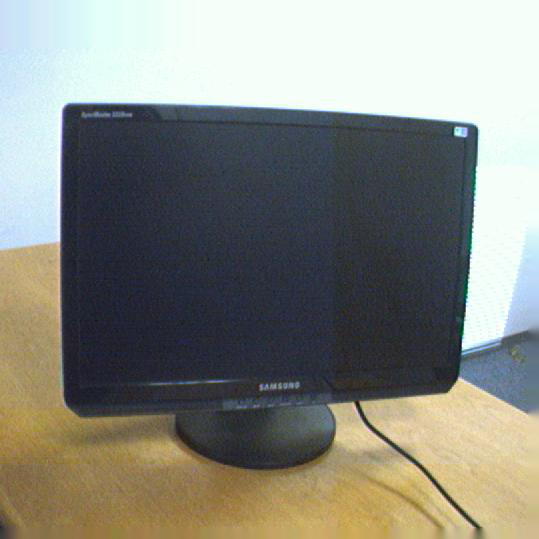

In [ ]:
import PIL.Image as PILImage
import numpy as np

pil_img = PILImage.open(img_dataset.samples[0][0])
print(pil_img.size)
pil_img

## RandomRotation

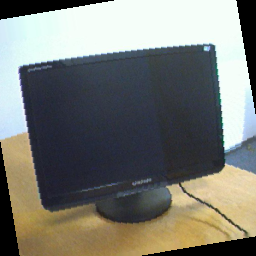

In [ ]:
random_rotation_ = transforms.Compose(
      [
          transforms.Resize((256, 256)),
          transforms.RandomRotation(15, interpolation=transforms.InterpolationMode.NEAREST),
      ]
)
random_rotation_(pil_img)

## CenterCrop

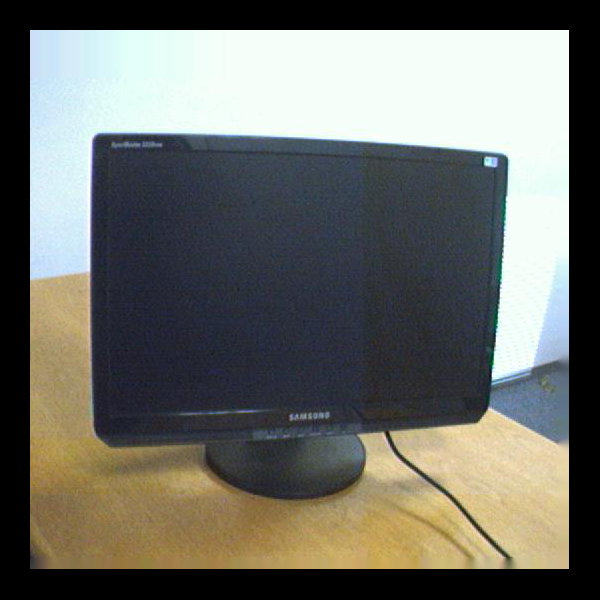

In [ ]:
center_crop_ = transforms.Compose([
    transforms.CenterCrop((600,600)),
])
center_crop_(pil_img)

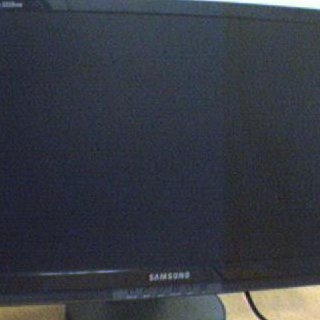

In [ ]:
center_crop_ = transforms.Compose([
    transforms.CenterCrop((320,320)),
])
center_crop_(pil_img)

## RandomCrop

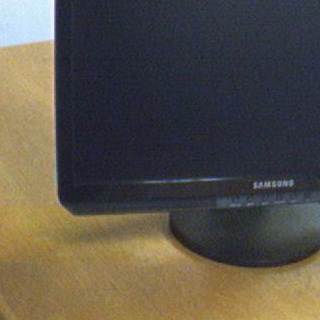

In [ ]:
random_crop_ = transforms.Compose([
    transforms.RandomCrop((320,320))
])
random_crop_(pil_img)

## ColorJitter

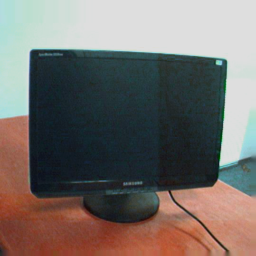

In [ ]:
color_jitter_ = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(
        brightness=0.2, 
        contrast=0.2, 
        saturation=0.2, 
        hue=(-0.1, 0.1))
])
color_jitter_(pil_img)

## RandomPerspective

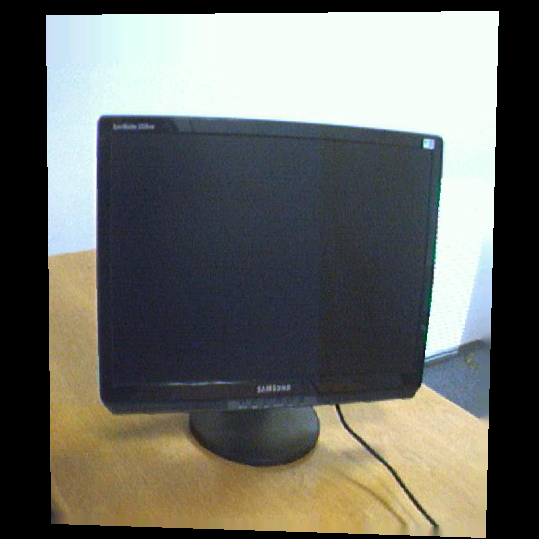

In [ ]:
random_perspective_ = transforms.Compose([
                transforms.RandomPerspective(distortion_scale=0.2, 
                              p=0.5, 
                              interpolation=transforms.InterpolationMode.NEAREST
                              )
])
random_perspective_(pil_img)

## RandomApply

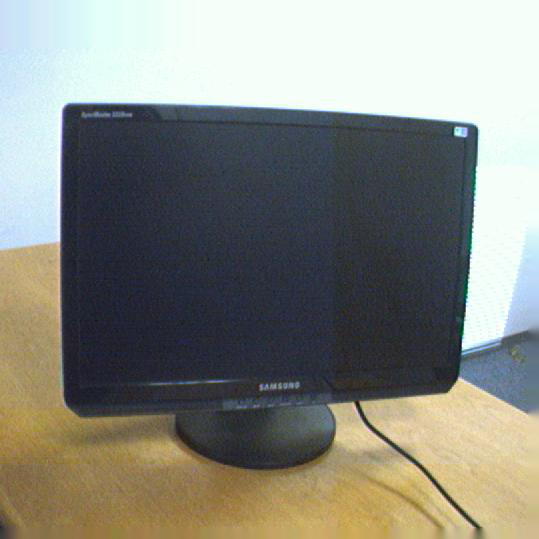

In [ ]:
transform_list = [
                transforms.RandomResizedCrop((256, 256), 
                              scale=(0.92, 1.0),
                              ratio=(1.0, 1.0), 
                              interpolation=transforms.InterpolationMode.NEAREST),
                transforms.RandomPerspective(distortion_scale=0.2, 
                              p=0.5, 
                              interpolation=transforms.InterpolationMode.NEAREST),
                transforms.RandomRotation(20, 
                            interpolation=transforms.InterpolationMode.NEAREST),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ColorJitter(brightness=0.2, 
                          contrast=0.5),

              ]
transforms.RandomApply(transform_list, p=0.5)(pil_img)